# **Step 1: Stock Price Analysis and Prediction**


# **Step 1.1: Importing Required Libraries for numerical analysis and prediction of stock prices**

Technical Stack used : 
* Numpy Array
* Matplotlib
* Pandas
* Keras
* Scikit Learn
* Math

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import yfinance as yf

In [399]:
quote='MRF.NS'

In [400]:
def get_historical(quote):
    end = datetime(2020,12,30)
    start = datetime(2001,1,2)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(''+quote+'.csv')
    if(df.empty):
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70',output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:'+quote, outputsize='full')
        #Format df
        #Last 2 yrs rows => 502, in ascending order => ::-1
        data=data.head(503).iloc[::-1]
        data=data.reset_index()
        #Keep Required cols only
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return

In [401]:
get_historical(quote)


[*********************100%***********************]  1 of 1 completed


# **Step 1.3 : Creating a dataframe for storing the Closing stock data per day**

In [402]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [403]:
df2 = pd.read_csv('MRF.NS.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

# **Step 1.4: Data Normalization and Division into Training and Test sets**

In [404]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [405]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# **Step 1.5 : Creating a LSTM Neural Network Model for Numerical Analysis**

In [406]:
# create and fit the LSTM networkworkbench.action.openLargeOutput
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)

Epoch 1/100
616/616 - 2s - loss: 0.0026 - 2s/epoch - 3ms/step
Epoch 2/100
616/616 - 1s - loss: 1.4471e-05 - 775ms/epoch - 1ms/step
Epoch 3/100
616/616 - 1s - loss: 1.1629e-05 - 744ms/epoch - 1ms/step
Epoch 4/100
616/616 - 1s - loss: 1.0485e-05 - 763ms/epoch - 1ms/step
Epoch 5/100
616/616 - 1s - loss: 9.8250e-06 - 745ms/epoch - 1ms/step
Epoch 6/100
616/616 - 1s - loss: 8.9902e-06 - 738ms/epoch - 1ms/step
Epoch 7/100
616/616 - 1s - loss: 8.8349e-06 - 740ms/epoch - 1ms/step
Epoch 8/100
616/616 - 1s - loss: 8.0889e-06 - 739ms/epoch - 1ms/step
Epoch 9/100
616/616 - 1s - loss: 7.9623e-06 - 750ms/epoch - 1ms/step
Epoch 10/100
616/616 - 1s - loss: 8.6893e-06 - 740ms/epoch - 1ms/step
Epoch 11/100
616/616 - 1s - loss: 9.6743e-06 - 741ms/epoch - 1ms/step
Epoch 12/100
616/616 - 1s - loss: 9.0499e-06 - 739ms/epoch - 1ms/step
Epoch 13/100
616/616 - 1s - loss: 8.9295e-06 - 725ms/epoch - 1ms/step
Epoch 14/100
616/616 - 1s - loss: 8.8030e-06 - 732ms/epoch - 1ms/step
Epoch 15/100
616/616 - 1s - loss: 8.

# **Step 1.6 : Making Predictions of the Model**

In [407]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

48/48 [==============================] - 0s 723us/step


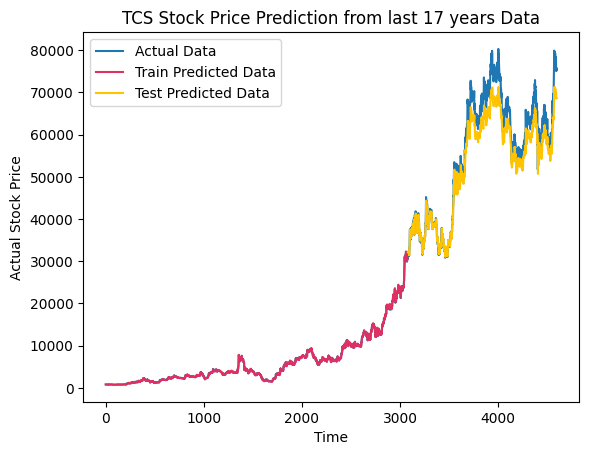

In [408]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2), label = 'Actual Data')
plt.title('TCS Stock Price Prediction from last 17 years Data')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.plot(trainPredictPlot,color='#DE3163', label = 'Train Predicted Data')
plt.plot(testPredictPlot, color='#FFC300', label = 'Test Predicted Data')
plt.legend(loc='best')
plt.show()

In [409]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error of Training  = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error of Testing = ",testScore," RMSE")


Root mean square error of Training  =  179.294272706234  RMSE
Root mean square error of Testing =  3676.3051036895968  RMSE


# **Step 2: Textual Data(News Headlines) Analysis**

# **Step 2.1:  Importing Required Libraries for Textual (News Headlines) analysis**

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

# **Step 2.2 : Importing the Textual dataset and performing Exploratory Analysis**

In [411]:
data = pd.read_csv('india-news-headlines.csv')
data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [412]:
data['publish_date'].duplicated()

0          False
1           True
2           True
3           True
4           True
           ...  
3650965     True
3650966     True
3650967     True
3650968     True
3650969     True
Name: publish_date, Length: 3650970, dtype: bool

In [413]:
data = data.drop_duplicates('publish_date', keep='first').sort_index()
data= data.reset_index()

In [414]:
data.rename(columns={'publish_date': 'Date'},inplace = True)
data.head()

,index,Date,headline_category,headline_text
0,0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,86,20010103,unknown,Powerless north India gropes in the dark
2,127,20010104,unknown,The string that pulled Stephen Hawking to India
3,280,20010105,unknown,Light combat craft takes India into club class
4,406,20010106,unknown,Light combat craft takes India into club class


In [415]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7717 entries, 0 to 7716
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              7717 non-null   int64 
 1   Date               7717 non-null   int64 
 2   headline_category  7717 non-null   object
 3   headline_text      7717 non-null   object
dtypes: int64(2), object(2)
memory usage: 241.3+ KB


In [416]:
data['headline_category'].value_counts()

headline_category
unknown                                  987
entertainment.hindi.bollywood            732
india                                    343
life-style.relationships.man-woman       332
edit-page                                256
                                        ... 
shobhaa-de.politically-incorrect           1
city.jammu                                 1
friendship-day                             1
entertainment.marathi.movies.previews      1
astrology.horoscope.yearly                 1
Name: count, Length: 330, dtype: int64

In [417]:
city_data = data[data['headline_category'].str.contains('^city\.[a-z]+$', regex=True)]
city_data

,index,Date,headline_category,headline_text
8,642,20010110,city.patna,Fend for yourselves; Pande tells doctors
48,2215,20010309,city.delhi,Maneka asks govt to take back land for cow she...
114,4563,20010522,city.pune,She turned and fought
116,4693,20010527,city.bengaluru,Need to boost exports; says bank head
118,4917,20010529,city.bengaluru,US visit won't be piece of cake for Krishna
...,...,...,...,...
7700,3642496,20220315,city.mumbai,Mumbaikars enjoy nightlife once more as restau...
7703,3643993,20220318,city.mumbai,Mumbai salons and spas deal with heavy demand ...
7707,3645983,20220322,city.patna,Sikta MLA pleads for police reform
7710,3647476,20220325,city.delhi,Speeding up; shortcuts and tackling unruly cus...


In [418]:
city_split = pd.DataFrame(columns=['city_name'])

In [419]:
city_split['city_name'] = city_data.headline_category.str.split('.',expand=True)[1]

In [420]:
# concate the data set city_data and city_split
city_data = pd.concat([city_data,city_split],axis=1)

In [421]:
# removing unnecessary column from dataset
city_data.drop(columns=['headline_category'],axis=1, inplace=True)

In [422]:
# re-setting the index
city_data.reset_index(inplace=True)

In [423]:
# see the final data which contain city_name column
city_data.head()

,level_0,index,Date,headline_text,city_name
0,8,642,20010110,Fend for yourselves; Pande tells doctors,patna
1,48,2215,20010309,Maneka asks govt to take back land for cow she...,delhi
2,114,4563,20010522,She turned and fought,pune
3,116,4693,20010527,Need to boost exports; says bank head,bengaluru
4,118,4917,20010529,US visit won't be piece of cake for Krishna,bengaluru


In [424]:
city_data.drop(['level_0', 'index'],axis=1)

,Date,headline_text,city_name
0,20010110,Fend for yourselves; Pande tells doctors,patna
1,20010309,Maneka asks govt to take back land for cow she...,delhi
2,20010522,She turned and fought,pune
3,20010527,Need to boost exports; says bank head,bengaluru
4,20010529,US visit won't be piece of cake for Krishna,bengaluru
...,...,...,...
1412,20220315,Mumbaikars enjoy nightlife once more as restau...,mumbai
1413,20220318,Mumbai salons and spas deal with heavy demand ...,mumbai
1414,20220322,Sikta MLA pleads for police reform,patna
1415,20220325,Speeding up; shortcuts and tackling unruly cus...,delhi


In [425]:
# there are so many cities which we can see
city_data.city_name.unique()

array(['patna', 'delhi', 'pune', 'bengaluru', 'ahmedabad', 'mumbai',
       'thiruvananthapuram', 'kolkata', 'hyderabad', 'lucknow',
       'chandigarh', 'goa', 'nagpur', 'guwahati', 'rajkot', 'bhubaneswar',
       'surat', 'allahabad', 'varanasi', 'vadodara', 'mangaluru',
       'ranchi', 'jaipur', 'ludhiana', 'mysuru', 'kanpur', 'thane',
       'hubballi', 'kochi', 'navimumbai', 'gurgaon', 'indore', 'kolhapur',
       'agartala', 'madurai', 'bareilly', 'aurangabad', 'meerut',
       'visakhapatnam', 'trichy', 'coimbatore', 'jammu', 'dehradun',
       'nashik', 'noida', 'puducherry', 'erode', 'chennai', 'jind',
       'ghaziabad', 'bhopal', 'jamshedpur', 'vijayawada', 'agra',
       'shimla', 'amritsar'], dtype=object)

# **Step 2.3: Representing number of headline text (News Headline) per city**

In [426]:
# create a group of cities and let's see which city have, how many no. of headine text
city_headline = city_data.groupby(['city_name']).agg({'headline_text':'count'})

In [427]:
#for better understanding remane the column
city_headline.rename(columns={'headline_text':'Number_of_headline_text'},inplace=True)

In [428]:
# finding the top 15 cities which have high number of headlines text
city_headline = city_headline.sort_values(by='Number_of_headline_text',ascending=False)
top_15_headline_city = city_headline.head(15)
top_15_headline_city

,Number_of_headline_text
city_name,
bengaluru,113
mumbai,94
delhi,84
ahmedabad,83
pune,78
hyderabad,75
patna,73
chandigarh,59
goa,57


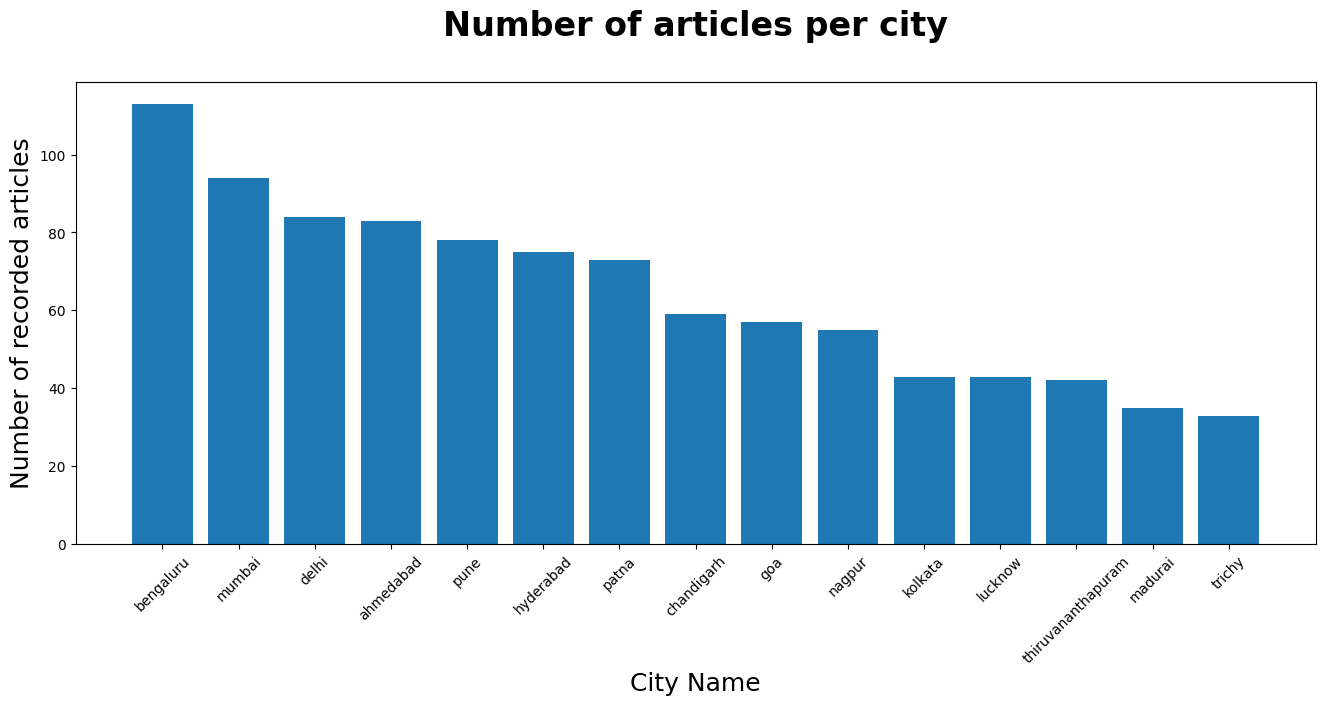

In [429]:
# plotting a graph for better understanding for top 15 cities which have high no. of headline text

plt.figure(figsize=(16,6))
plt.bar(top_15_headline_city.index,height=top_15_headline_city['Number_of_headline_text'])
plt.xticks(rotation = 45)
plt.xlabel('City Name',fontsize=18)
plt.ylabel('Number of recorded articles',fontsize=18)
plt.title('Number of articles per city\n',fontsize=24, fontweight='bold')
plt.show()

# **Step 2.4: Representing Number of News Headlines per year and per city**

In [430]:
city_data['Date'] = pd.to_datetime(city_data['Date'])
city_data.head()

,level_0,index,Date,headline_text,city_name
0,8,642,1970-01-01 00:00:00.020010110,Fend for yourselves; Pande tells doctors,patna
1,48,2215,1970-01-01 00:00:00.020010309,Maneka asks govt to take back land for cow she...,delhi
2,114,4563,1970-01-01 00:00:00.020010522,She turned and fought,pune
3,116,4693,1970-01-01 00:00:00.020010527,Need to boost exports; says bank head,bengaluru
4,118,4917,1970-01-01 00:00:00.020010529,US visit won't be piece of cake for Krishna,bengaluru


In [431]:
city_data['Year'] = city_data['Date'].apply(lambda x: (x.year))

In [432]:
# dropping unnecessary columns
city_data.drop(columns=['Date','index'],axis=1,inplace=True)

In [433]:
# final result
city_data.head()

,level_0,headline_text,city_name,Year
0,8,Fend for yourselves; Pande tells doctors,patna,1970
1,48,Maneka asks govt to take back land for cow she...,delhi,1970
2,114,She turned and fought,pune,1970
3,116,Need to boost exports; says bank head,bengaluru,1970
4,118,US visit won't be piece of cake for Krishna,bengaluru,1970


In [434]:
city_data_2 = city_data.copy()
city_data_2['Number_of_headline_text'] = 1

In [435]:
# dropping unwanted column
city_data_2.drop(columns=['headline_text'],axis=1, inplace=True)

In [436]:
city_data_2.head()

,level_0,city_name,Year,Number_of_headline_text
0,8,patna,1970,1
1,48,delhi,1970,1
2,114,pune,1970,1
3,116,bengaluru,1970,1
4,118,bengaluru,1970,1


In [437]:
top_15_headline_city.head(7)

,Number_of_headline_text
city_name,
bengaluru,113
mumbai,94
delhi,84
ahmedabad,83
pune,78
hyderabad,75
patna,73


In [438]:
# creating new data_set for top 7 cities with year 

city_beng = city_data_2[city_data_2.city_name == 'bengaluru']
city_del = city_data_2[city_data_2.city_name == 'delhi']
city_ahme = city_data_2[city_data_2.city_name == 'ahmedabad']
city_mum = city_data_2[city_data_2.city_name == 'mumbai']
city_pune = city_data_2[city_data_2.city_name == 'pune']
city_hyd = city_data_2[city_data_2.city_name == 'hyderabad']
city_luck = city_data_2[city_data_2.city_name == 'luck']

In [439]:
famous_cities = [city_beng, city_del, city_ahme, city_mum, city_pune, city_hyd, city_luck]
data_famous_cities = pd.concat(famous_cities)

In [440]:
# reset index numbers
data_famous_cities.reset_index(inplace=True)

In [441]:
# top 7 cities
print(data_famous_cities.shape)
data_famous_cities.head()

(527, 5)


,index,level_0,city_name,Year,Number_of_headline_text
0,3,116,bengaluru,1970,1
1,4,118,bengaluru,1970,1
2,5,119,bengaluru,1970,1
3,7,135,bengaluru,1970,1
4,10,138,bengaluru,1970,1


In [442]:
data_famous_cities=data_famous_cities.drop(['level_0'],axis=1)
data_famous_cities.head()

,index,city_name,Year,Number_of_headline_text
0,3,bengaluru,1970,1
1,4,bengaluru,1970,1
2,5,bengaluru,1970,1
3,7,bengaluru,1970,1
4,10,bengaluru,1970,1


In [443]:
# year-wise no. of headlines text
city_year_count = pd.Series(city_data_2.groupby(['Year'])['Number_of_headline_text'].count())

# year-wise data which shows which city have how many no. of headline text
city_count = data_famous_cities.groupby(['Year', 'city_name']).sum()['Number_of_headline_text'].unstack()

In [444]:
city_count.head()

city_name,ahmedabad,bengaluru,delhi,hyderabad,mumbai,pune
Year,,,,,,
1970,83,113,84,75,94,78


In [445]:
city_year_count.head()

Year
1970    1417
Name: Number_of_headline_text, dtype: int64

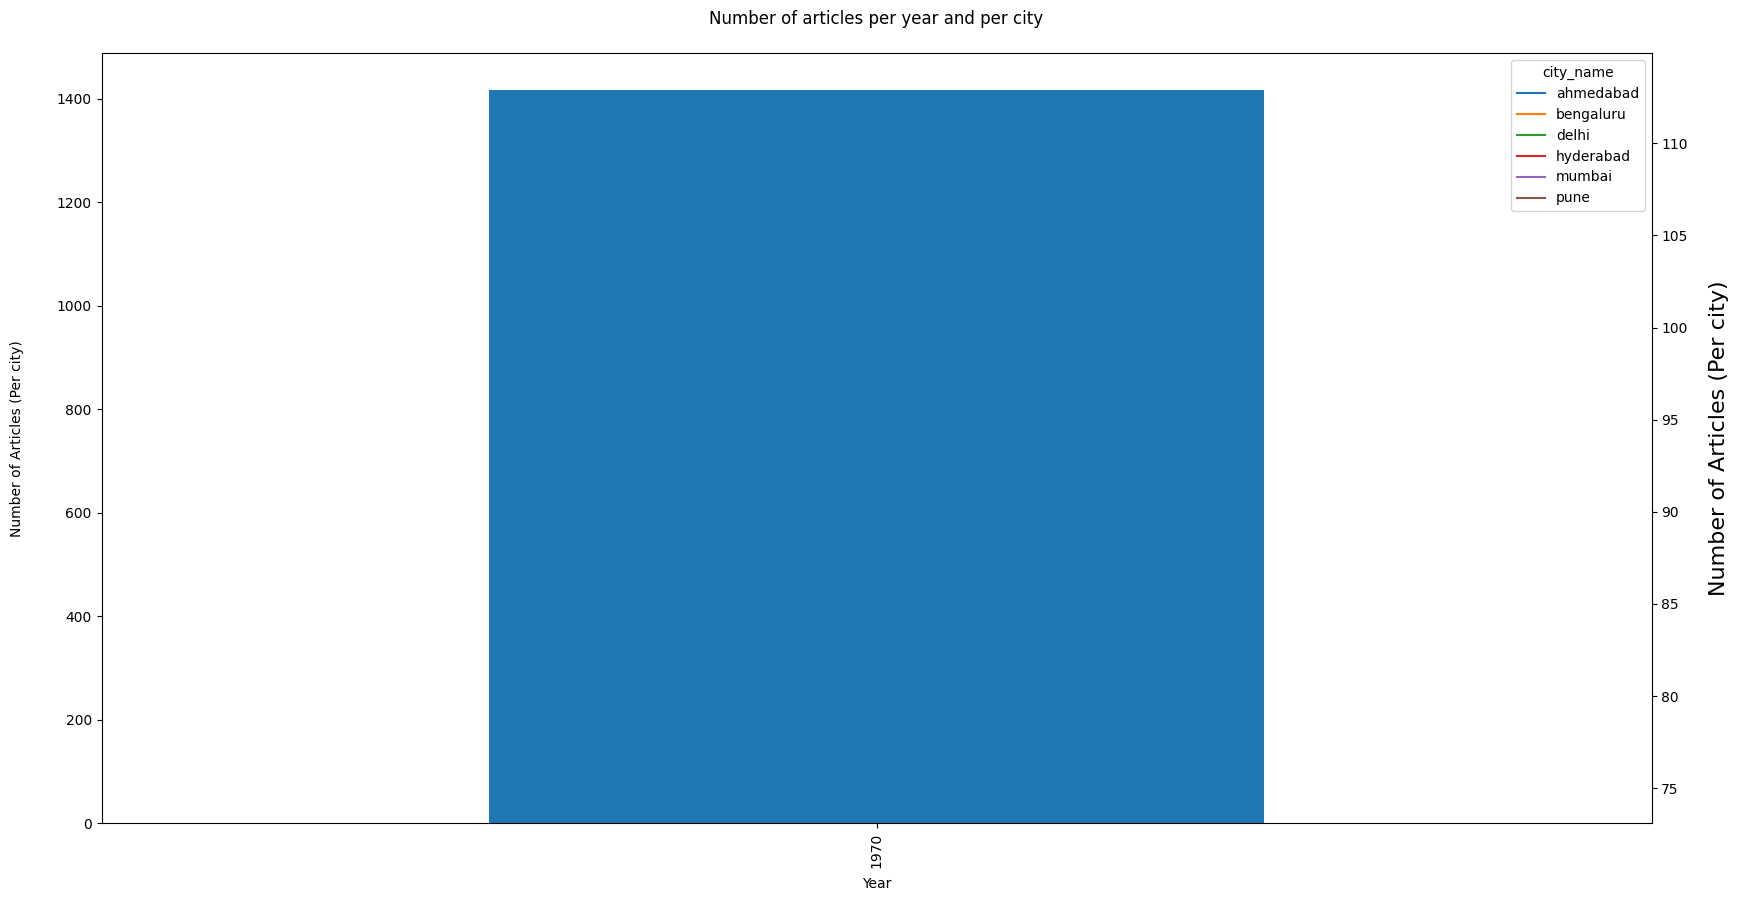

<Figure size 2000x1000 with 0 Axes>

In [446]:
fig=plt.figure()

a = fig.add_subplot(111,label="1")
b = fig.add_subplot(111,label="2", frame_on = False)

plt.figure(figsize=(20,10))
city_year_count.plot(kind='bar',figsize=(20,10), ax=a,title="Number of articles per year and per city\n")
a.set_ylabel('Number of Articles (Per city)')
a.set_xlabel("")

city_count.plot(ax=b)
b.set_xticks([])
b.set_ylabel('Number of Articles (Per city)', size =16)
b.yaxis.tick_right()
b.set_xlabel('Year') 

a.get_yaxis().set_label_coords(-.05,0.5)
b.get_yaxis().set_label_coords(1.05,0.5)
b.get_xaxis().set_label_coords(0.5, -0.07)

plt.show()

# **Step 2.5: Sentiment Analysis of News Headlines**

In [447]:
def getAnalysis_polarity(headline):
    result = TextBlob(headline)
    
    if result.sentiment.polarity < 0:
        return 'negative'
    elif result.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'positive'

In [448]:
data['Result'] = np.array([getAnalysis_polarity(headline) for headline in data['headline_text']])

In [449]:
final_result = data.groupby(['Result']).agg({'headline_text':'count'})
final_result

,headline_text
Result,
negative,773
neutral,5113
positive,1831


In [450]:
negative = (final_result.loc['negative'] / len(data))*100
neutral = (final_result.loc['neutral'] / len(data))*100
positive = (final_result.loc['positive'] / len(data))*100


print('Positive Headlines: ' , positive )
print('\n\nNegative Headlines: ' ,negative )
print('\n\nUnbiased Headlines: ' , str(neutral))

Positive Headlines:  headline_text    23.726837
Name: positive, dtype: float64


Negative Headlines:  headline_text    10.016846
Name: negative, dtype: float64


Unbiased Headlines:  headline_text    66.256317
Name: neutral, dtype: float64


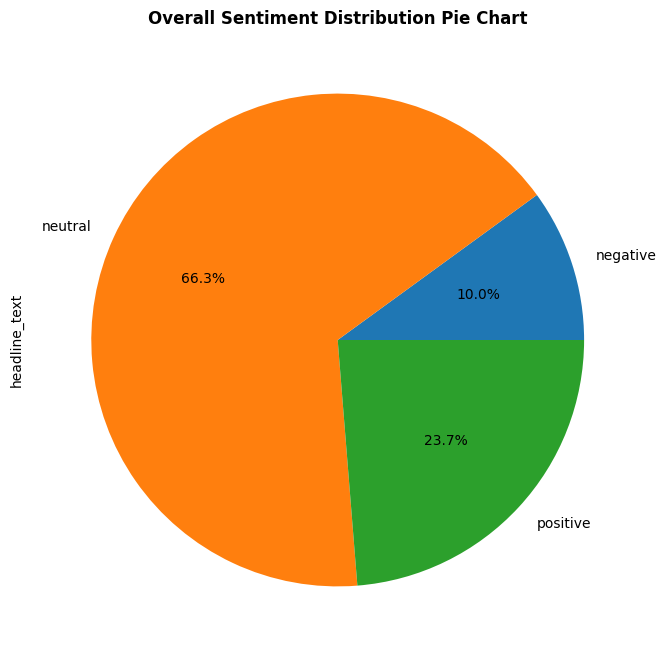

In [451]:
plt.figure(figsize=(8,8))
final_result['headline_text'].plot.pie(autopct='%1.1f%%')
plt.title("Overall Sentiment Distribution Pie Chart",fontweight="bold")
plt.show()

# **Step 3: Creating Hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines**

# **Step 3.1: Importing Required Libraries**

In [452]:
%pip install vaderSentiment



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [453]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# **Step 3.2 : Importing the Numerical and Textual dataset**

In [455]:
stock_data=pd.read_csv('MRF.NS.csv')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623


In [456]:
news_data=pd.read_csv('india-news-headlines.csv')
news_data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [457]:
news_data.rename(columns={'publish_date': 'Date'},inplace = True)
news_data.head()

,Date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# **Step 3.3: Creating Hybrid data from Numerical and Textual Data**

In [458]:
hybrid_data = pd.merge(stock_data, news_data, left_index=True, right_index=True, how='inner')


In [459]:
hybrid_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_y,headline_category,headline_text
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310,20010102,unknown,Fissures in Hurriyat over Pak visit
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336,20010102,unknown,America's unwanted heading for India?
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591,20010102,unknown,For bigwigs; it is destination Goa
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623,20010102,unknown,Extra buses to clear tourist traffic


# **Step 3.4: Performing Sentiment Analysis on Hybrid Data**

## **Step 3.4.1: Sentiment Analysis using TextBlob**

In [460]:
def analysis_polarity(headline):
    result = TextBlob(headline)
    
    if result.sentiment.polarity < 0:
        return 'negative'
    elif result.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'positive'

In [461]:
hybrid_data['sentiment'] = np.array([analysis_polarity(headline) for headline in hybrid_data['headline_text']])
hybrid_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_y,headline_category,headline_text,sentiment
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,neutral
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310,20010102,unknown,Fissures in Hurriyat over Pak visit,neutral
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336,20010102,unknown,America's unwanted heading for India?,neutral
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591,20010102,unknown,For bigwigs; it is destination Goa,neutral
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623,20010102,unknown,Extra buses to clear tourist traffic,positive


In [462]:
senti_data = pd.get_dummies(hybrid_data['sentiment'],drop_first=True)

In [463]:
hybrid_data = pd.concat([hybrid_data,senti_data],axis=1)

In [464]:
hybrid_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_y,headline_category,headline_text,sentiment,neutral,positive
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,neutral,True,False
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310,20010102,unknown,Fissures in Hurriyat over Pak visit,neutral,True,False
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336,20010102,unknown,America's unwanted heading for India?,neutral,True,False
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591,20010102,unknown,For bigwigs; it is destination Goa,neutral,True,False
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623,20010102,unknown,Extra buses to clear tourist traffic,positive,False,True


## **Step 3.4.2: Adding subjectivity and polarity Scores to Textual Data (News Headlines)**

In [465]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [466]:
#Adding subjectivity and polarity columns
hybrid_data['Subjectivity'] =hybrid_data['headline_text'].apply(getSubjectivity)
hybrid_data['Polarity'] = hybrid_data['headline_text'].apply(getPolarity)
hybrid_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_y,headline_category,headline_text,sentiment,neutral,positive,Subjectivity,Polarity
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,neutral,True,False,0.000000,0.00
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310,20010102,unknown,Fissures in Hurriyat over Pak visit,neutral,True,False,0.000000,0.00
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336,20010102,unknown,America's unwanted heading for India?,neutral,True,False,0.000000,0.00
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591,20010102,unknown,For bigwigs; it is destination Goa,neutral,True,False,0.000000,0.00
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623,20010102,unknown,Extra buses to clear tourist traffic,positive,False,True,0.241667,0.05


## **Step 3.4.3: Visualizing the polarity and Subjectivity scores**


<Axes: title={'center': 'News Polarity'}>

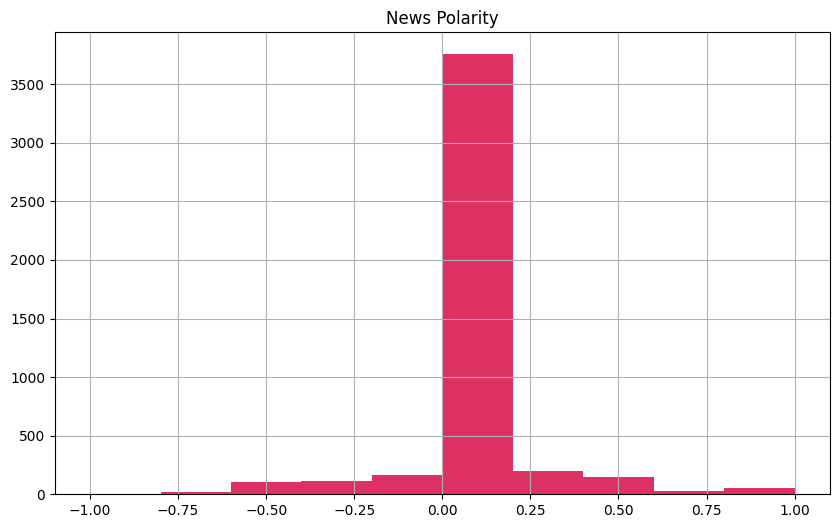

In [467]:
plt.figure(figsize = (10,6))
plt.title('News Polarity')
hybrid_data['Polarity'].hist(color = '#DE3163')

<Axes: title={'center': 'News Subjectivity'}>

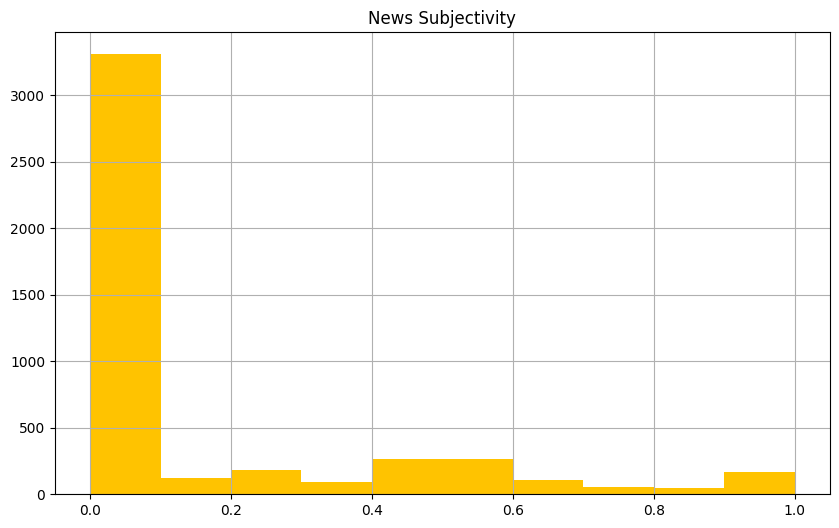

In [468]:
plt.figure(figsize = (10,6))
plt.title('News Subjectivity')
hybrid_data['Subjectivity'].hist(color = '#FFC300')

## **Step 3.4.4 : Performing Sentiment Analysis over the news Headlines of Hybrid Data**

In [469]:
#Adding sentiment score to news
senti_int_an = SentimentIntensityAnalyzer()

hybrid_data['Compound'] = [senti_int_an.polarity_scores(v)['compound'] for v in hybrid_data['headline_text']]
hybrid_data['Negative'] = [senti_int_an.polarity_scores(v)['neg'] for v in hybrid_data['headline_text']]
hybrid_data['Neutral'] = [senti_int_an.polarity_scores(v)['neu'] for v in hybrid_data['headline_text']]
hybrid_data['Positive'] = [senti_int_an.polarity_scores(v)['pos'] for v in hybrid_data['headline_text']]
hybrid_data.head()

,Date_x,Open,High,Low,Close,Adj Close,Volume,Date_y,headline_category,headline_text,sentiment,neutral,positive,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2002-07-01,910.0,910.0,880.0,897.599976,814.252014,426,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,neutral,True,False,0.000000,0.00,0.2924,0.000,0.805,0.195
1,2002-07-02,900.0,905.0,895.0,903.650024,819.740479,310,20010102,unknown,Fissures in Hurriyat over Pak visit,neutral,True,False,0.000000,0.00,0.0000,0.000,1.000,0.000
2,2002-07-03,910.0,910.0,900.0,906.700012,822.507324,336,20010102,unknown,America's unwanted heading for India?,neutral,True,False,0.000000,0.00,-0.2263,0.322,0.678,0.000
3,2002-07-04,920.0,925.0,910.0,916.799988,831.669312,591,20010102,unknown,For bigwigs; it is destination Goa,neutral,True,False,0.000000,0.00,0.0000,0.000,1.000,0.000
4,2002-07-05,915.0,935.0,910.0,927.299988,841.194336,1623,20010102,unknown,Extra buses to clear tourist traffic,positive,False,True,0.241667,0.05,0.3818,0.000,0.658,0.342


In [470]:
hybrid_data.columns

Index(['Date_x', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Date_y', 'headline_category', 'headline_text', 'sentiment', 'neutral',
       'positive', 'Subjectivity', 'Polarity', 'Compound', 'Negative',
       'Neutral', 'Positive'],
      dtype='object')

In [471]:
req_col = [ 'Open',  'High', 'Low','Volume','Compound', 'Negative', 'Neutral' ,'Positive','positive']

In [472]:
new_hybrid = hybrid_data[req_col]
new_hybrid.reset_index(inplace = True)

In [473]:
new_hybrid.rename(columns = {'positive':'Label'}, inplace = True)

C:\Users\soham\AppData\Local\Temp\ipykernel_10900\2165816261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_hybrid.rename(columns = {'positive':'Label'}, inplace = True)


In [474]:
new_hybrid.head()

,index,Open,High,Low,Volume,Compound,Negative,Neutral,Positive,Label
0,0,910.0,910.0,880.0,426,0.2924,0.000,0.805,0.195,False
1,1,900.0,905.0,895.0,310,0.0000,0.000,1.000,0.000,False
2,2,910.0,910.0,900.0,336,-0.2263,0.322,0.678,0.000,False
3,3,920.0,925.0,910.0,591,0.0000,0.000,1.000,0.000,False
4,4,915.0,935.0,910.0,1623,0.3818,0.000,0.658,0.342,True


In [475]:
new_hybrid.shape


(4597, 10)

In [476]:
new_hybrid.describe(include='all')


,index,Open,High,Low,Volume,Compound,Negative,Neutral,Positive,Label
count,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3808
mean,2298.000000,22662.732273,22948.163721,22361.413459,8551.351751,0.000024,0.091512,0.807623,0.100866,NaN
std,1327.183923,25002.309765,25270.688772,24703.482898,11572.276189,0.300437,0.180598,0.239844,0.190536,NaN
min,0.000000,779.450012,828.000000,779.450012,0.000000,-0.895700,0.000000,0.000000,0.000000,NaN
25%,1149.000000,3199.000000,3245.000000,3110.000000,2151.000000,0.000000,0.000000,0.625000,0.000000,NaN
50%,2298.000000,7726.700195,7830.000000,7585.000000,5529.000000,0.000000,0.000000,1.000000,0.000000,NaN
75%,3447.000000,40187.000000,40688.000000,39656.050781,10561.000000,0.000000,0.000000,1.000000,0.158000,NaN


In [477]:
print(new_hybrid.mean())


index        2298.000000
Open        22662.732273
High        22948.163721
Low         22361.413459
Volume       8551.351751
Compound        0.000024
Negative        0.091512
Neutral         0.807623
Positive        0.100866
Label           0.171634
dtype: float64


In [478]:
pos=new_hybrid.mean()['Positive']
print(pos)
neg=new_hybrid.mean()['Negative']
print(neg)
neu=new_hybrid.mean()['Neutral']
print(neu)

0.10086621709810746
0.09151185555797259
0.8076225799434413


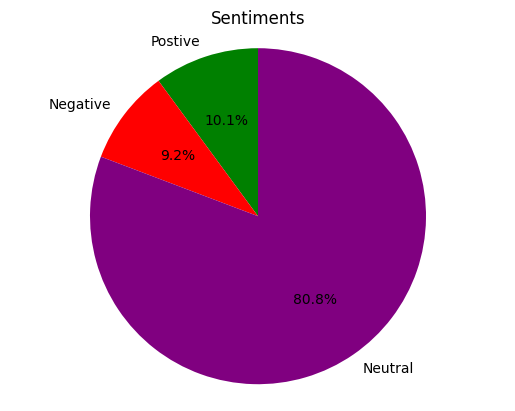

In [479]:
# Data for the pie chart
labels = ['Postive','Negative','Neutral']
sizes = [pos,neg,neu]  # The values should add up to 100
colors = ['green', 'red', 'purple']

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Sentiments')

# Show the plot
plt.show()

In [480]:
def sentimentcall():
    if pos > 1.5*neg :
        print("SELL THE STOCK!!!!!!!!")
    elif neg>1.5*pos:
        print("BUY THE STOCK!!!!!!!!")
    else:
        print("HOLD THE STOCK!!!!!!")

In [481]:
sentimentcall()

HOLD THE STOCK!!!!!!


# **Step 3.5: Training and Testing the Models for Stock Price/Performance Analysis**

In [482]:
X = new_hybrid.drop('Label', axis=1)    

y = new_hybrid['Label']  

In [483]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)


In [484]:
np.any(np.isnan(x_train)) 

False

In [485]:
np.all(np.isfinite(x_train)) 

True

In [486]:
x_train = x_train.fillna(x_train.mean())

In [487]:
x_test=x_test.fillna(x_test.mean())

## **Step 3.5.1: Stock Price/Performance analysis using Logistic Regressor Model**

In [488]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [489]:
logit = LogisticRegression()
logit.fit(x_train,y_train)
y_logit_pred = logit.predict(x_test)
print(accuracy_score(y_test,y_logit_pred))
print(precision_score(y_test,y_logit_pred))
print(recall_score(y_test,y_logit_pred))
print(f1_score(y_test,y_logit_pred))


0.8402173913043478
0.5
0.013605442176870748
0.02649006622516556


## **Step 3.5.2: Stock Price/Performance analysis using Random Forest Model**

In [490]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(x_train,y_train)
y_rf_pred = rf.predict(x_test)
print(accuracy_score(y_test,y_rf_pred))
print(precision_score(y_test,y_rf_pred))
print(recall_score(y_test,y_rf_pred))
print(f1_score(y_test,y_rf_pred))

0.8684782608695653
0.6625
0.36054421768707484
0.46696035242290745


## **Step 3.5.3 : Stock Price/Performance analysis using Decision Tree Model**

In [491]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_dt_pred = dt.predict(x_test)
print(accuracy_score(y_test,y_dt_pred))
print(precision_score(y_test,y_dt_pred))
print(recall_score(y_test,y_dt_pred))
print(f1_score(y_test,y_dt_pred))

0.7956521739130434
0.37423312883435583
0.41496598639455784
0.3935483870967742


## **Step 3.5.6: Stock Price/Performance analysis using Logistic Gradient Boosting Model**

In [492]:
xgb = GradientBoostingClassifier()
xgb.fit(x_train, y_train)
y_xgb_pred = xgb.predict(x_test)
print(accuracy_score(y_test,y_xgb_pred))
print(precision_score(y_test,y_xgb_pred))
print(recall_score(y_test,y_xgb_pred))
print(f1_score(y_test,y_xgb_pred))

0.866304347826087
0.7
0.2857142857142857
0.40579710144927533


In [493]:
print("Accuracy of Logistic Regression Model: ",accuracy_score(y_test,y_logit_pred)*100,"%")
print("Accuracy of Random forest Model      : ",accuracy_score(y_test,y_rf_pred)*100,"%")
print("Accuracy of Decision Tree Model      : ",accuracy_score(y_test,y_dt_pred)*100,"%")
print("Accuracy of Gradient Boosting Model  : ",accuracy_score(y_test,y_xgb_pred)*100,"%")

Accuracy of Logistic Regression Model:  84.02173913043478 %
Accuracy of Random forest Model      :  86.84782608695653 %
Accuracy of Decision Tree Model      :  79.56521739130434 %
Accuracy of Gradient Boosting Model  :  86.6304347826087 %


# **Conclusion:**

Here, I have used six different Neural Network models to carry out the analysis and prediction of stock price/performance and train them with Hybrid data generated from Numerical data (i.e. Last 17 years Stock price/performance records of TCS (Tata Consultancy Service)) and Textual data (i.e.India News Headlines data). 

WI have found accuracy of  each model as mention below:


1. Logistic Regression Model:  83.22032395127025 %
2. Random forest Model      :  81.19986132499133 %
3. Decision Tree Model      :  79.30759245672454 %
4. **Gradient Boosting Model  :  85.5213615950851 %**

 At the end, we can clearly see that Gradient Boosing Model gives more accuracy(i.e. 85.5%)  as compared to all other models.Gradient Boosting Model has 85.5% accuracy which means it performs better  on Analysis and prediction of Stock price/performance than other 5 Neural Network Models.